In [30]:
using CSV, PyPlot, Distributions, DataFrames, MCMCDiagnostics, LinearAlgebra
const e = MathConstants.e;

In [2]:
# import simulated data (Real data will be released upon publication of Castro Dopico et al.)
df = CSV.read("../Data/simulated_data.csv")
times = [14,17,18,19,20,21,22,23,24,25];

In [3]:
# Constructing training (- and +) and population datasets
function extract_datasubset(df,str_w)
    filt = df[:,:type] .== str_w
    return hcat(ones(sum(filt)), convert(Matrix, df[filt,[:SPIKE,:RBD]]))
end

# Training data
train_neg = extract_datasubset(df,"t-")
train_pos = extract_datasubset(df,"t+")

# Population data
pop_data = [extract_datasubset(df,"w$(t)") for t in times];

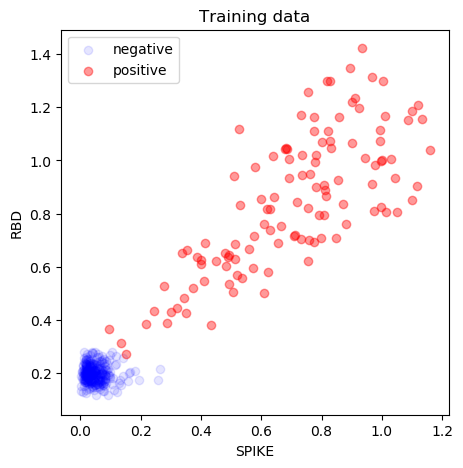

In [8]:
# Plot negative and positive training data ###
figure(figsize=(5,5))
scatter(train_neg[:,2],train_neg[:,3], color = "blue", alpha = 0.1, label = "negative")
scatter(train_pos[:,2],train_pos[:,3], color = "red", alpha = 0.4, label = "positive")
xlabel("SPIKE")
ylabel("RBD")
legend()
title("Training data");

## Estimate $\beta$ parameters

In [9]:
#log-likelihood for class-balance adjusted logistic regression to infer betas
logistic(x) = 1/(1+e^(-x));

function regr_ll(pos, neg, betas, cor)  #pos and neg matrices must have a first column of ones
    #contributions from pos training samples
    ll = sum(log.(logistic.(pos*betas .+ cor))) 
    #contributions from neg training samples 
    ll += sum(log.(1 .- logistic.(neg*betas .+ cor)))     
    return ll
end;

In [10]:
# priors over betas
prior_sd = 20.0
beta_priors = [Normal(0.0,prior_sd), Normal(0.0,prior_sd), Normal(0.0,prior_sd)];

In [12]:
#Sample posterior betas with MCMC (Metropolis' algorithm)

# class-balance correction term
cb_cor = log(size(train_pos)[1]/size(train_neg)[1]);

# number of iterations, burn-in, and number of samples to push to beta_chain
num_iters = 200000
burn_in = 10000
num_samples = 1000

# randomly select indices at which to push samples to beta_chain
to_push = sample(burn_in:num_iters, num_samples, replace = false)
beta_chain = []

# initialise
betas = [0.0, 0.0, 0.0]
lpriors = sum(logpdf.(beta_priors, betas))
ll = regr_ll(train_pos,train_neg,betas,cb_cor)

# keep track of number of proposals accepted
accepts = 0

for i in 1:num_iters
    new_betas = betas .+ 2*randn(length(betas))
    new_lpriors = sum(logpdf.(beta_priors, new_betas))
    new_ll = regr_ll(train_pos,train_neg,new_betas,cb_cor)
    
    if rand() < exp(new_ll + new_lpriors - ll - lpriors)
        accepts += 1
        betas = new_betas
        lpriors = new_lpriors
        ll = new_ll
    end
    if i in to_push
            push!(beta_chain, [betas, ll])
        end
end

# acceptance rate
println("Acceptance rate: ",accepts/num_iters)

Acceptance rate: 0.37131


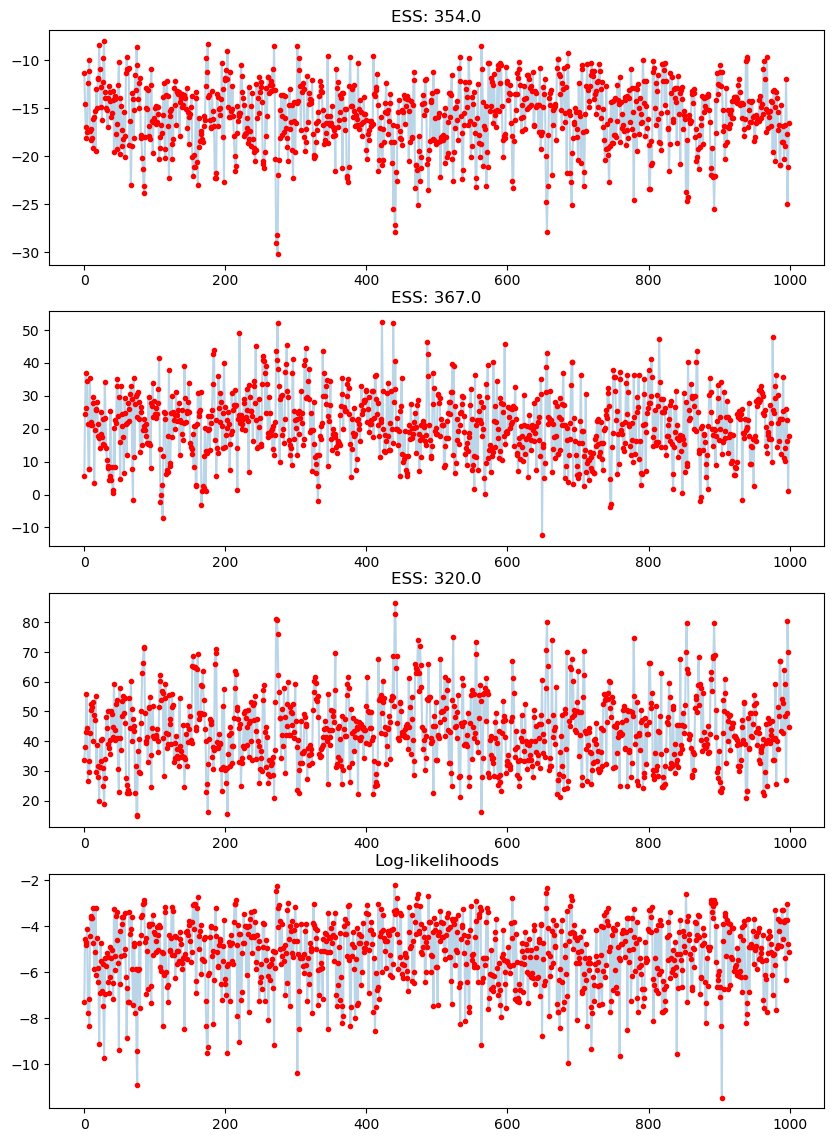

beta0 quantiles: [-23.078, -15.5184, -10.0574]
beta1 quantiles: [2.5191, 21.0988, 40.5238]
beta2 quantiles: [23.1931, 42.7893, 69.4399]


In [13]:
# Inspect convergence of the chain
beta0_samples = [b[1][1] for b in beta_chain]
beta1_samples = [b[1][2] for b in beta_chain]
beta2_samples = [b[1][3] for b in beta_chain]
ll_samples = [b[2] for b in beta_chain]

figure(figsize=(10,14))
subplot(4,1,1)
plot(beta0_samples, alpha = 0.3)
plot(beta0_samples, color = "red", ".")
title("ESS: $(round(effective_sample_size(beta0_samples)))")
subplot(4,1,2)
plot(beta1_samples, alpha = 0.3);
plot(beta1_samples, color = "red", ".")
title("ESS: $(round(effective_sample_size(beta1_samples)))")
subplot(4,1,3)
plot(beta2_samples, alpha = 0.3);
plot(beta2_samples, color = "red", ".")
title("ESS: $(round(effective_sample_size(beta2_samples)))")
subplot(4,1,4)
plot(ll_samples, alpha = 0.3);
plot(ll_samples, color = "red", ".")
title("Log-likelihoods")

println("beta0 quantiles: $(quantile(beta0_samples, [0.025,0.5,0.975]))")
println("beta1 quantiles: $(quantile(beta1_samples, [0.025,0.5,0.975]))")
println("beta2 quantiles: $(quantile(beta2_samples, [0.025,0.5,0.975]))")

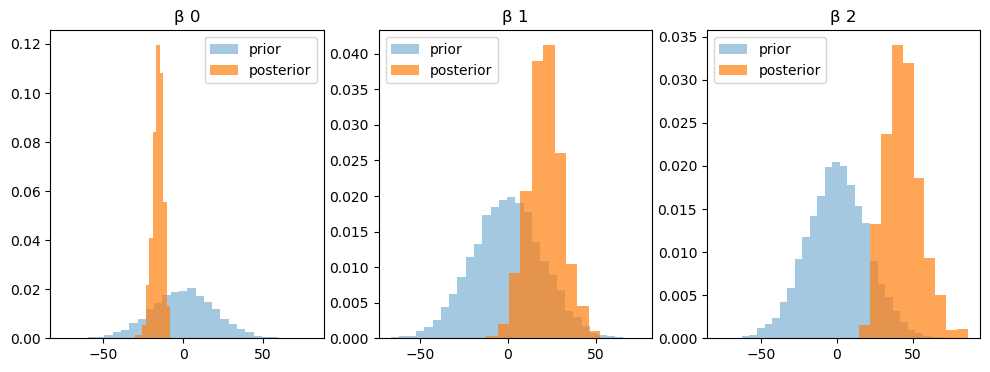

In [28]:
#Inspect priors vs posteriors

figure(figsize=(12,4))
subplot(1,3,1)
hist(rand(beta_priors[1],10000),30, density = true, alpha = 0.4, label = "prior")
hist(beta0_samples, alpha = 0.7,density = true, label = "posterior")
legend()
title("β 0")
subplot(1,3,2)
hist(rand(beta_priors[2],10000),30, density = true, alpha = 0.4, label = "prior")
hist(beta1_samples, alpha = 0.7, density = true, label = "posterior")
legend()
title("β 1")
subplot(1,3,3)
hist(rand(beta_priors[3],10000),30, density = true, alpha = 0.4, label = "prior")
hist(beta2_samples, alpha = 0.7, density = true, label = "posterior")
legend()
title("β 2");

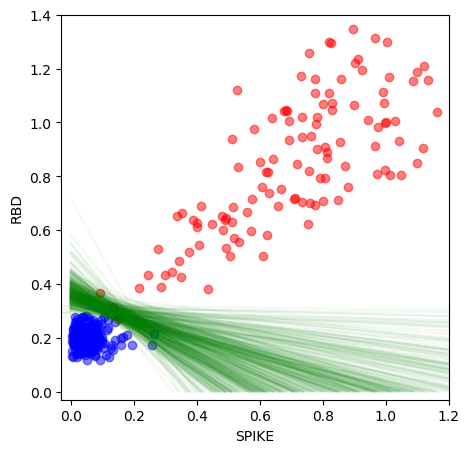

In [15]:
# Visualize the posterior distribution over decision boundaries
function plot_level_line(betas, prob, cor; alpha = 1, color = "black")
    beta0, beta1, beta2 = betas
    x2_int = (log(prob/(1-prob)) - cor - beta0)/beta2
    x1_int = (log(prob/(1-prob)) - cor - beta0)/beta1
    plot([0,x1_int],[x2_int, 0], alpha = alpha, color = color)
end

figure(figsize = (5,5))

beta_samples = [b[1] for b in beta_chain]

for beta in sample(beta_samples,500, replace=false)
    #Note, these set "cor" to 0, which gives them a "class balanced" interpretation.
    plot_level_line(beta, 0.5, 0, alpha = 0.05, color = "green")
end

scatter(train_neg[:,2],train_neg[:,3], color = "blue", alpha = 0.5, label = "negative")
scatter(train_pos[:,2],train_pos[:,3], color = "red", alpha = 0.5, label = "positive")
xlim(-0.03,1.2)
ylim(-0.03, 1.4)
xlabel("SPIKE")
ylabel("RBD");

## Gaussian Process definitions

In [16]:
# get covariance matrix from kernel
function get_cov_mat(kern,X; eps = 10^-7)
    hcat([[kern(x1,x2) for x1 in X] for x2 in X]...) + Diagonal(zeros(length(X)) .+ eps) # eps for numerics
end

# Rational quadratic kernels (see: "Gaussian Processes for Machine Learning")
function RQkern(x1,x2; params=[2.0,5.0,0.5])
    sigma = params[1]
    l = params[2]
    a = params[3]
    return (sigma^2) * (1+((x1-x2)^2)/(2*a*(l^2)))^-a
end;

In [17]:
# map a curve from the Gaussian Process to the corresponding prevalence trajectory
function GPtoPrevalence(start,GPdraws)
    out = zeros(length(GPdraws)+1)
    out[1] = start
    for i in 2:length(out)
        remaining = 1-out[i-1]
        out[i] = out[i-1] + logistic(GPdraws[i-1]) * remaining
    end
    return out
end;

In [18]:
function get_MVNs(X)  #this is where we alter the lengthscale etc. of the Gaussian Process
    #Precomputing the proposal MultivariateNormal - zero mean, with low variance
    proposal_kern(x1,x2) = RQkern(x1,x2, params=[1.0,5.0,0.5])
    prop_cov_mat = get_cov_mat(proposal_kern,X);
    prop_mu = zeros(length(X))
    prop_MVN = MvNormal(prop_mu,prop_cov_mat);

    #using a fixed GP prior (ie. no hyperparameters), we can precompute the MultivariateNormal for the likelihood
    increase_kern(x1,x2) = RQkern(x1,x2, params=[2.0,5.0,0.5])
    mu_vec = zeros(length(X)) .- 7;
    cov_mat = get_cov_mat(increase_kern,X);
    GP_MVN = MvNormal(mu_vec,cov_mat);
    return prop_MVN, GP_MVN
end;

## Estimate prevalence  $\theta_1, \cdots, \theta_w$

In [19]:
#log-likelihood for population data from one time
function data_ll(data, betas, theta) #data matrix must have a first column of ones
    prob_if_pos = logistic.(data*betas)
    prob_arr = prob_if_pos.*theta .+ (1 .- prob_if_pos).*(1 - theta)
    ll = sum(log.(prob_arr))
    return ll
end;

In [20]:
#set up Gaussian process
all_times = [times[1]:1:times[end];]
X = all_times[2:end]
prop_MVN, GP_MVN = get_MVNs(X)

#collect the indices for all_weeks that correspond to weeks for which we have data
data_inds = []
for i in 1:length(all_times)
    if all_times[i] in times
        push!(data_inds, i)
    end
end

In [21]:
# For each posterior beta sample, sample posterior thetas conditioned on beta with MCMC

#posterior beta samples
beta_samples = [b[1] for b in beta_chain]

#theta1_prior
theta1_prior = Beta(1,15)

#number of iterations and burnin
num_iters = 10000
burn = 1000

#initialise chain
chain = []

#initialise parameter values
theta1 = rand(theta1_prior)
GP_draws = rand(GP_MVN)
theta_vec = GPtoPrevalence(theta1, GP_draws)

#Nested MCMC - outer loop over sampled βs
for j in 1:length(beta_samples)
    betas = beta_samples[j]

    #initialise parameter values at the values of the last sample
    lprior = logpdf(theta1_prior, theta1) + logpdf(GP_MVN, GP_draws)
    ll = sum([data_ll(pop_data[i],betas, theta_vec[data_inds[i]])  for i in 1:length(times)])

    ch = []

    #Nested MCMC - inner loop for each β
    for i in 1:num_iters
        new_theta1 = theta1 + 0.005*randn()
        new_GP_draws = GP_draws .+ rand(prop_MVN) 
        new_lprior = logpdf(theta1_prior, new_theta1) + logpdf(GP_MVN, new_GP_draws)
        new_theta_vec = GPtoPrevalence(new_theta1, new_GP_draws)

        if new_lprior > -Inf

            new_ll = sum([data_ll(pop_data[i],betas, new_theta_vec[data_inds[i]]) for i in 1:length(times)])

            if rand() < exp((new_ll + new_lprior) - (ll + lprior))
                theta1 = new_theta1
                GP_draws = new_GP_draws
                theta_vec = new_theta_vec
                ll = new_ll
                lprior = new_lprior
            end
        end 
        if (i > burn)&&(rem(i,20)==0)
            push!(ch, theta_vec)
        end
    end
    theta_min_ess = minimum([effective_sample_size([c[i] for c in ch]) for i in 1:length(theta_vec)])
    push!(chain, [theta_vec, theta_min_ess])
end

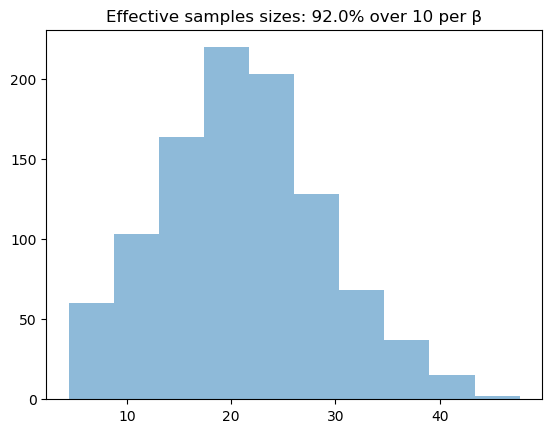

In [29]:
# examine the effective sample sizes of the MCMC chain sampling posterior thetas, for each posterior beta sample
ess = [c[2] for c in chain]

hist(ess, alpha = 0.5)
title("Effective samples sizes: $(round(100*sum(ess .> 10)/length(ess)))% over 10 per β");

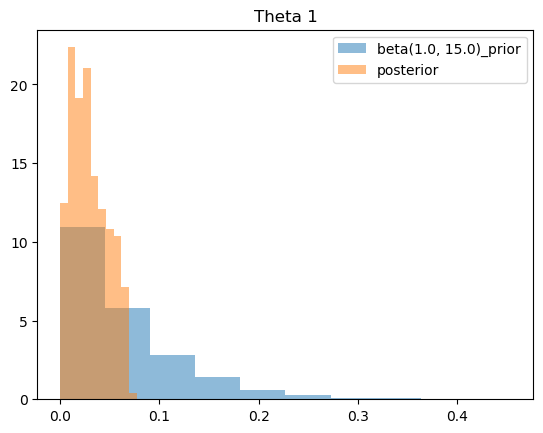

In [23]:
#plot the theta1 prior vs posterior
hist(rand(theta1_prior,10000), density = true, alpha = 0.5, label = "beta$(params(theta1_prior))_prior")
hist([c[1][1] for c in chain], density = true, alpha = 0.5, label = "posterior")
legend()
title("Theta 1") ; 

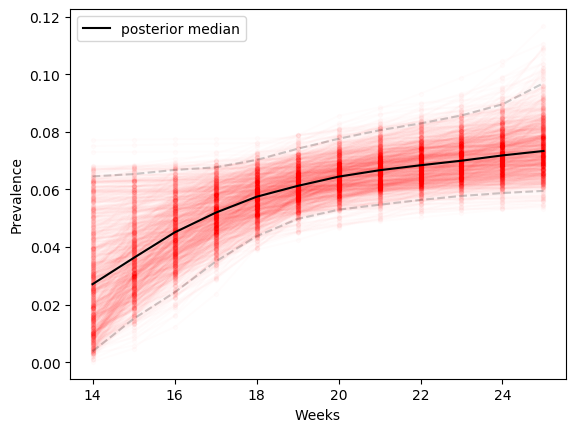

In [24]:
#plot the posterior trajectories
theta_samples = [[c[1][i] for c in chain] for i in 1:length(all_times)]

for c in chain
    plot(all_times, c[1] ,color = "red", alpha = 0.01)
    plot(all_times, c[1] ,".",color = "red", alpha = 0.01)
end
plot(all_times, [quantile(theta_samples[i],0.025) for i in 1:length(all_times)],"--", color = "black", alpha = 0.2)
plot(all_times, [quantile(theta_samples[i],0.975) for i in 1:length(all_times)],"--", color = "black", alpha = 0.2)
plot(all_times, [median(theta_samples[i]) for i in 1:length(all_times)], color = "black", label = "posterior median")
xlabel("Weeks")
ylabel("Prevalence")
legend();

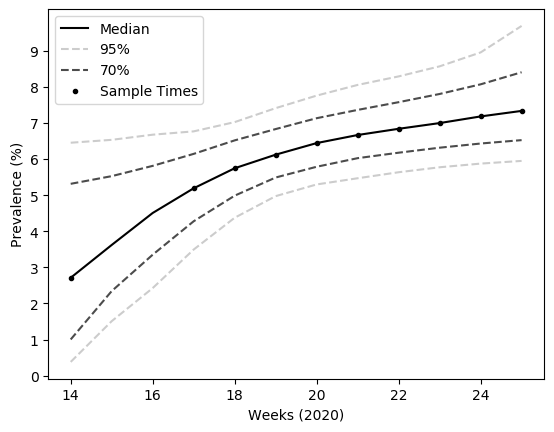

In [25]:
#plot posterior quantile curves
theta_samples = [[c[1][i] for c in chain] for i in 1:length(all_times)]

med = [median(theta_samples[i]) for i in 1:length(all_times)]
low95 = [quantile(theta_samples[i],0.025) for i in 1:length(all_times)]
high95 = [quantile(theta_samples[i],0.975) for i in 1:length(all_times)]
low70 = [quantile(theta_samples[i],0.15) for i in 1:length(all_times)]
high70 = [quantile(theta_samples[i],0.85) for i in 1:length(all_times)]

plot(all_times, med, color = "black", label = "Median")
plot(all_times, low95,"--", color = "black", alpha = 0.2,label = "95%")
plot(all_times, high95,"--", color = "black", alpha = 0.2)
plot(all_times, low70,"--", color = "black", alpha = 0.7,label = "70%")
plot(all_times, high70,"--", color = "black", alpha = 0.7)

plot(times,med[times .- times[1] .+ 1],".",color = "black", label = "Sample Times")

xlabel("Weeks (2020)")
ylabel("Prevalence (%)")
legend()
yticks([0.0:0.01:0.09;],[0:1:9;]);